In [17]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

import os
from os.path import dirname
import re
import time
import datetime

In [1]:
trainfile = 'train.csv'
testfile = 'test.csv'

cols_list = ['pickup_datetime', 'passenger_count', \
             'pickup_latitude', 'pickup_longitude', \
             'dropoff_latitude', 'dropoff_longitude', \
             'trip_duration']

taxi_df = pd.read_csv('../_data/' + trainfile, usecols=cols_list)
taxi_df.head()

,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,4/30/16 23:59,1,-73.987793,40.724792,-73.975616,40.656445,1454
1,4/30/16 23:59,1,-73.957596,40.717770,-73.951424,40.775230,1409
2,4/30/16 23:59,2,-74.000954,40.742031,-73.947708,40.782200,1081
3,4/30/16 23:58,1,-73.985733,40.738258,-73.993179,40.754890,800
4,4/30/16 23:58,1,-74.006615,40.740650,-73.985619,40.723362,1151


In [44]:
test_df = pd.read_csv('../_data/' + testfile, usecols=cols_list[:-1])
test_df.head()

,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,6/30/16 23:59,5,-73.998291,40.722618,-73.971779,40.762470
1,6/30/16 23:59,2,-73.955109,40.689564,-73.978203,40.685802
2,6/30/16 23:59,1,-73.978416,40.791576,-73.973160,40.675968
3,6/30/16 23:59,2,-73.873093,40.774097,-73.926704,40.856739
4,6/30/16 23:58,1,-73.979416,40.755211,-74.003548,40.738224


In [45]:
# filtered_df = taxi_df[(taxi_df['pickup_longitude'] < -73.77) \
#                  & (-74.03 < taxi_df['pickup_longitude']) \
#                  & (40.62 < taxi_df['pickup_latitude']) \
#                  & (40.87 > taxi_df['pickup_latitude'])]
filtered_df = taxi_df[(taxi_df['pickup_longitude'] < -73.85) \
                 & (-74.10 < taxi_df['pickup_longitude']) \
                 & (40.70 < taxi_df['pickup_latitude']) \
                 & (40.87 > taxi_df['pickup_latitude'])]

filtered_df = filtered_df[(filtered_df['dropoff_longitude'] < -73.85) \
                 & (-74.10 < filtered_df['dropoff_longitude']) \
                 & (40.70 < filtered_df['dropoff_latitude']) \
                 & (40.87 > filtered_df['dropoff_latitude'])]
filtered_df.shape

(648904, 7)

In [17]:
small_df = filtered_df.sample(n=200)
small_df.shape

(200, 7)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B7AB9D47F0>]], dtype=object)

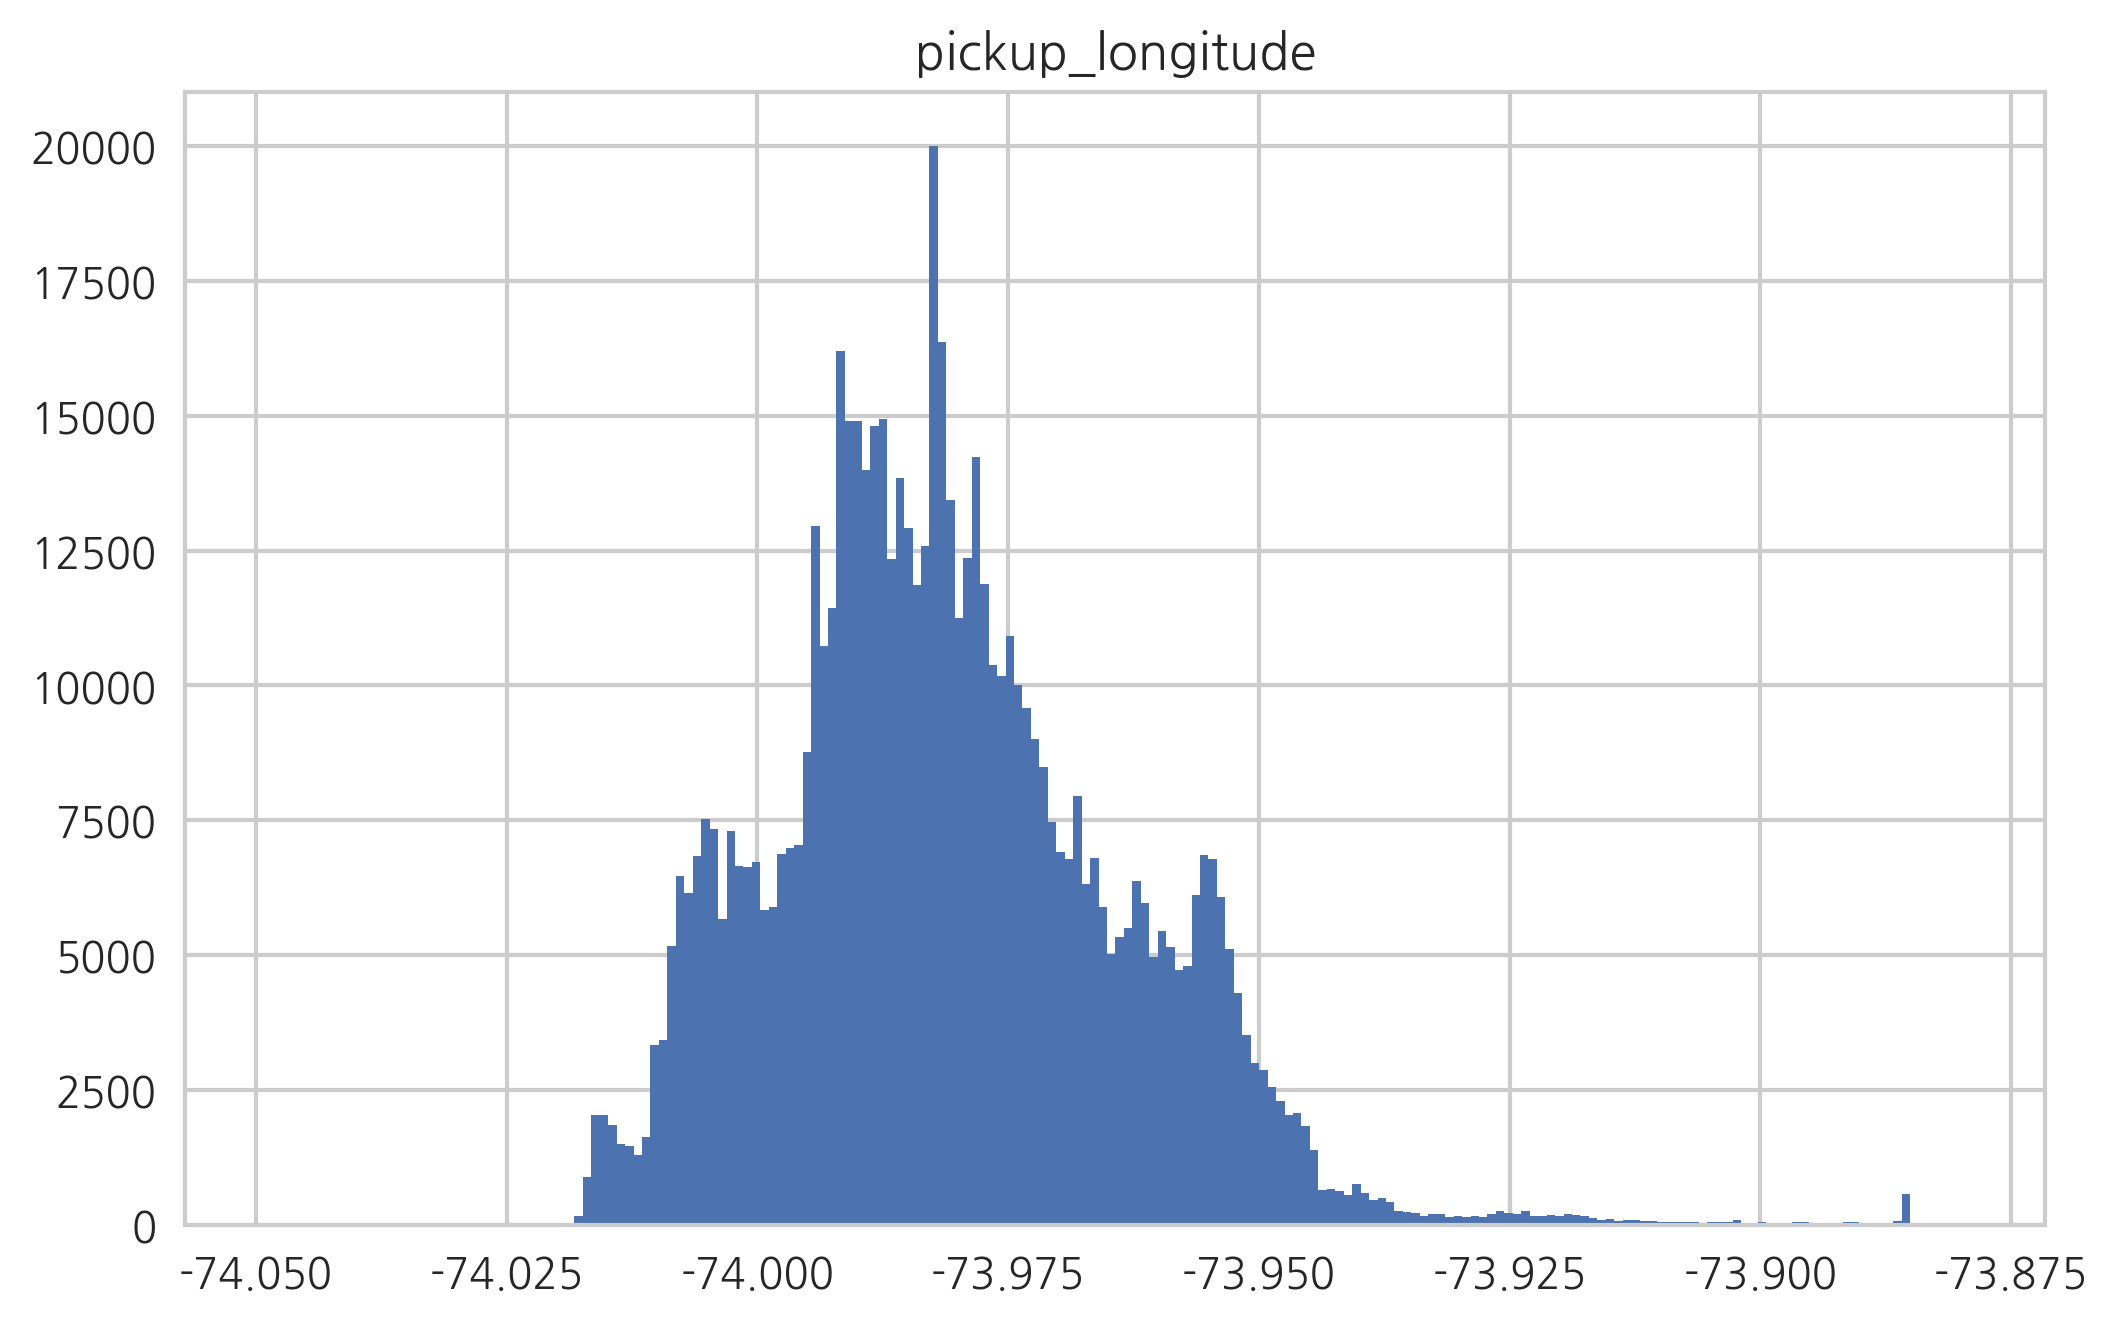

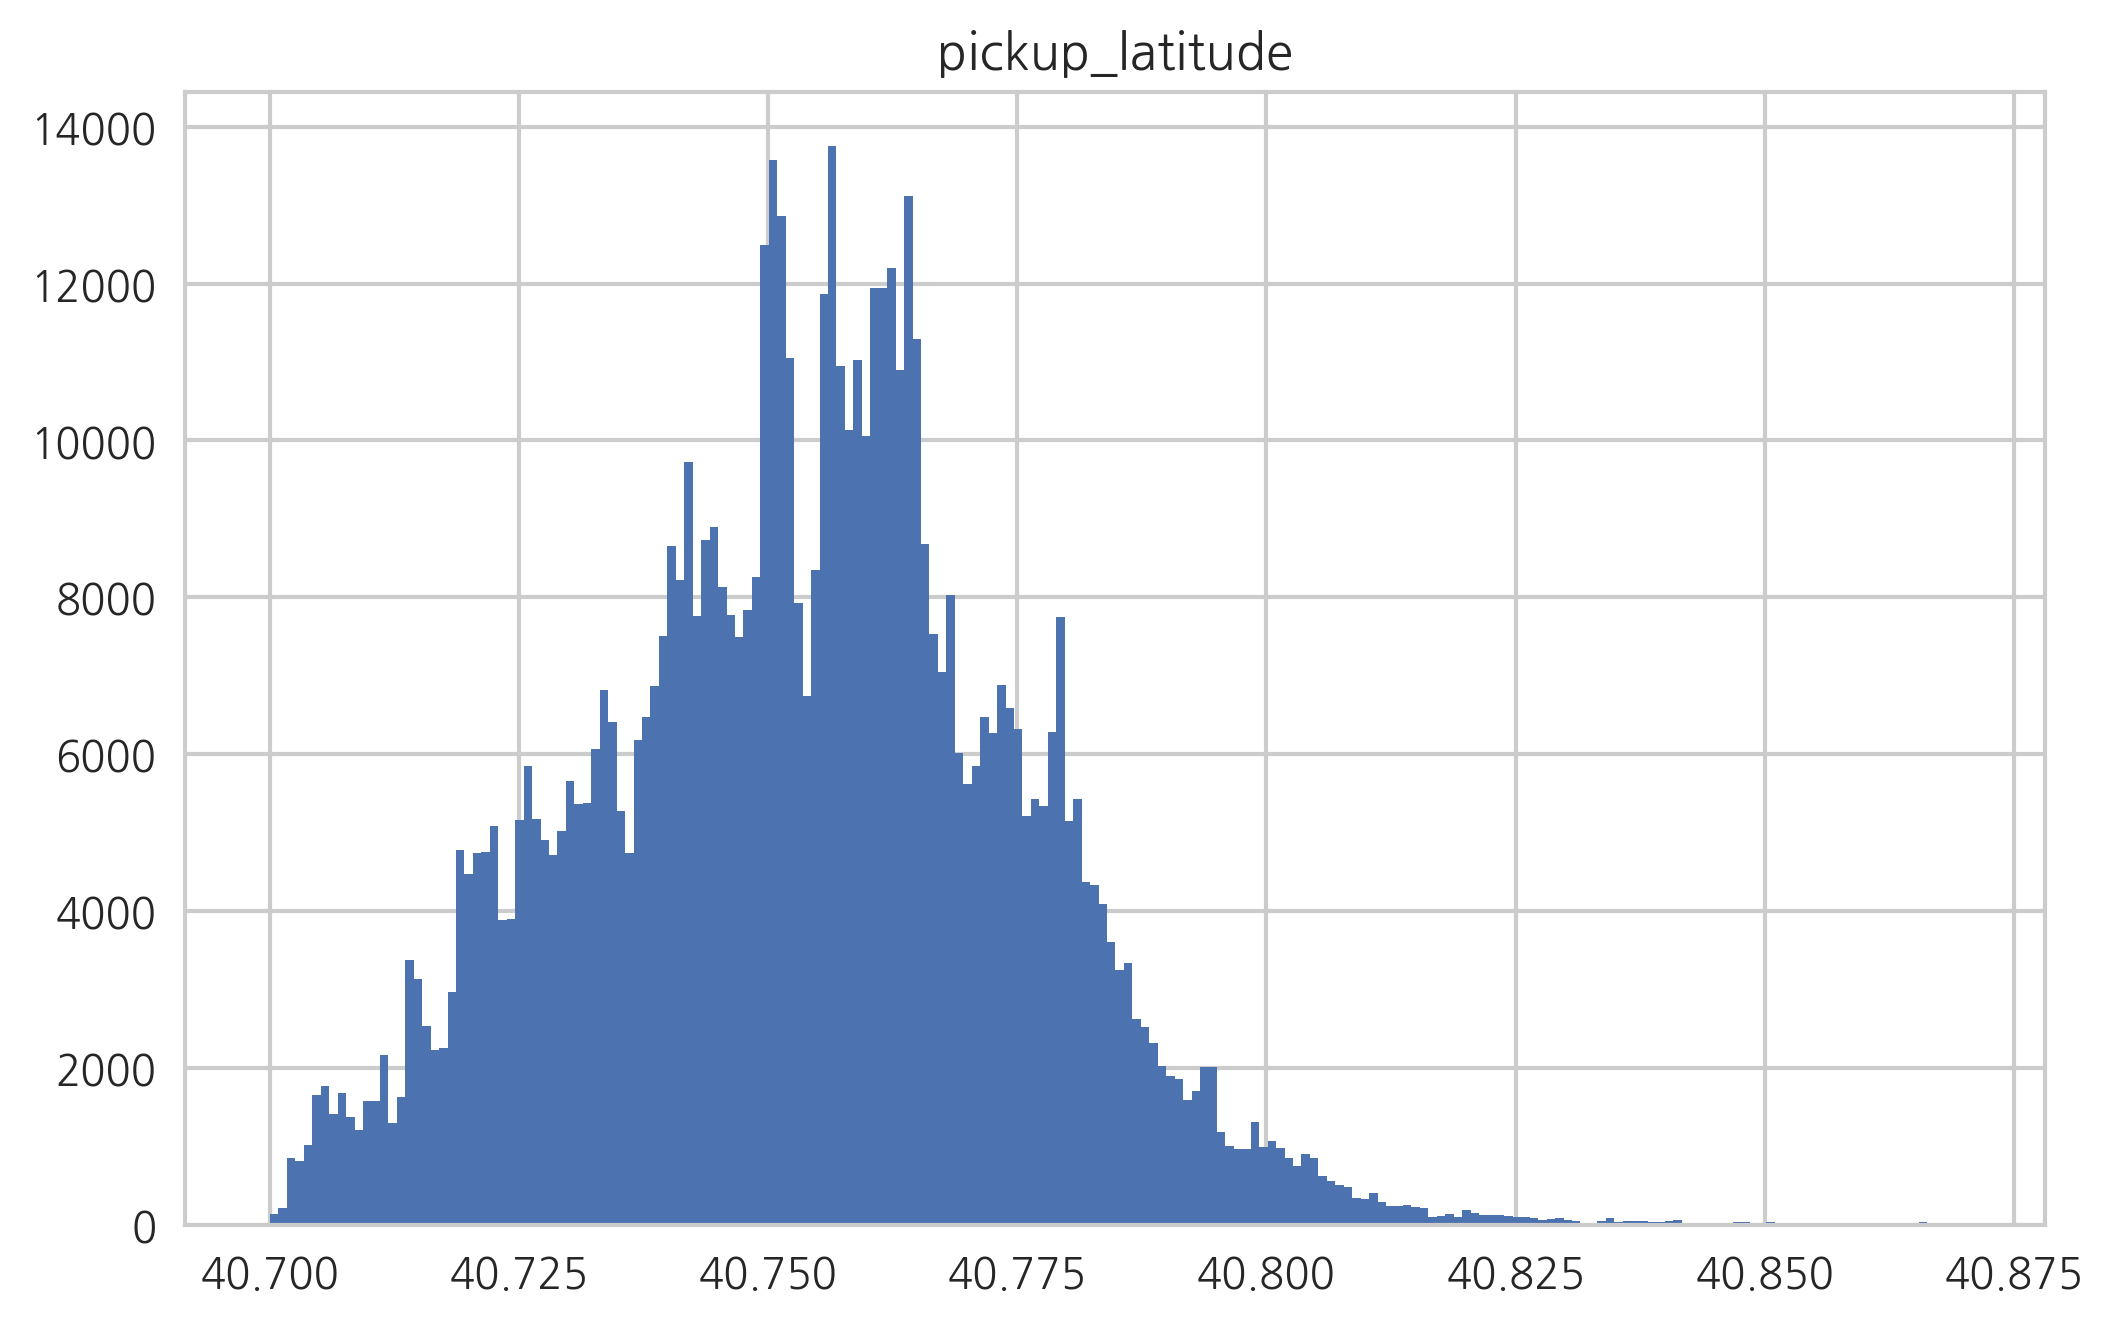

In [37]:
filtered_df.hist(column='pickup_longitude', bins=200)
filtered_df.hist(column='pickup_latitude', bins=200)

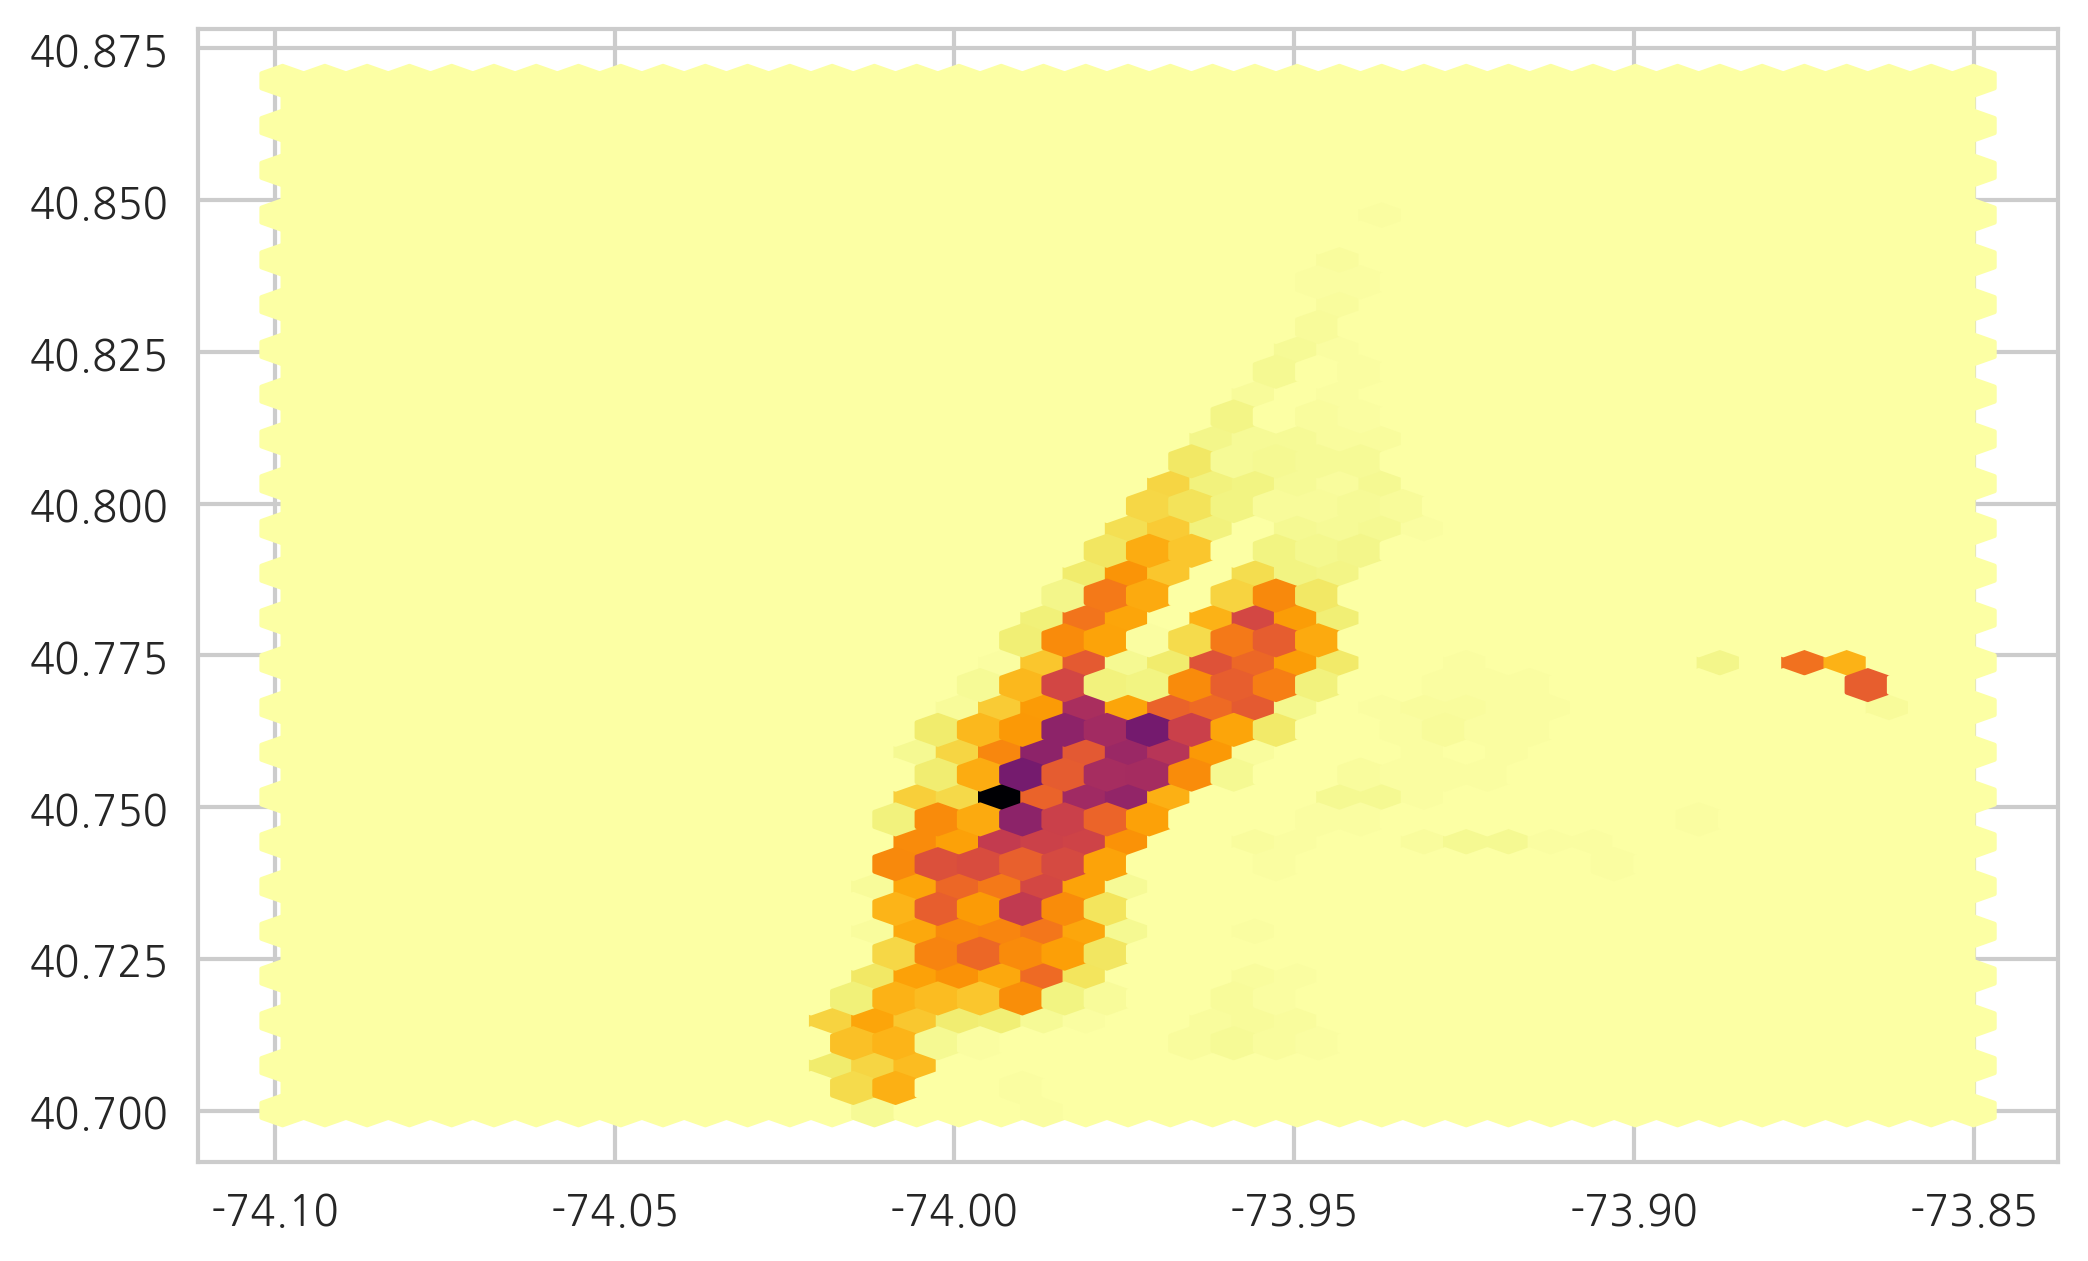

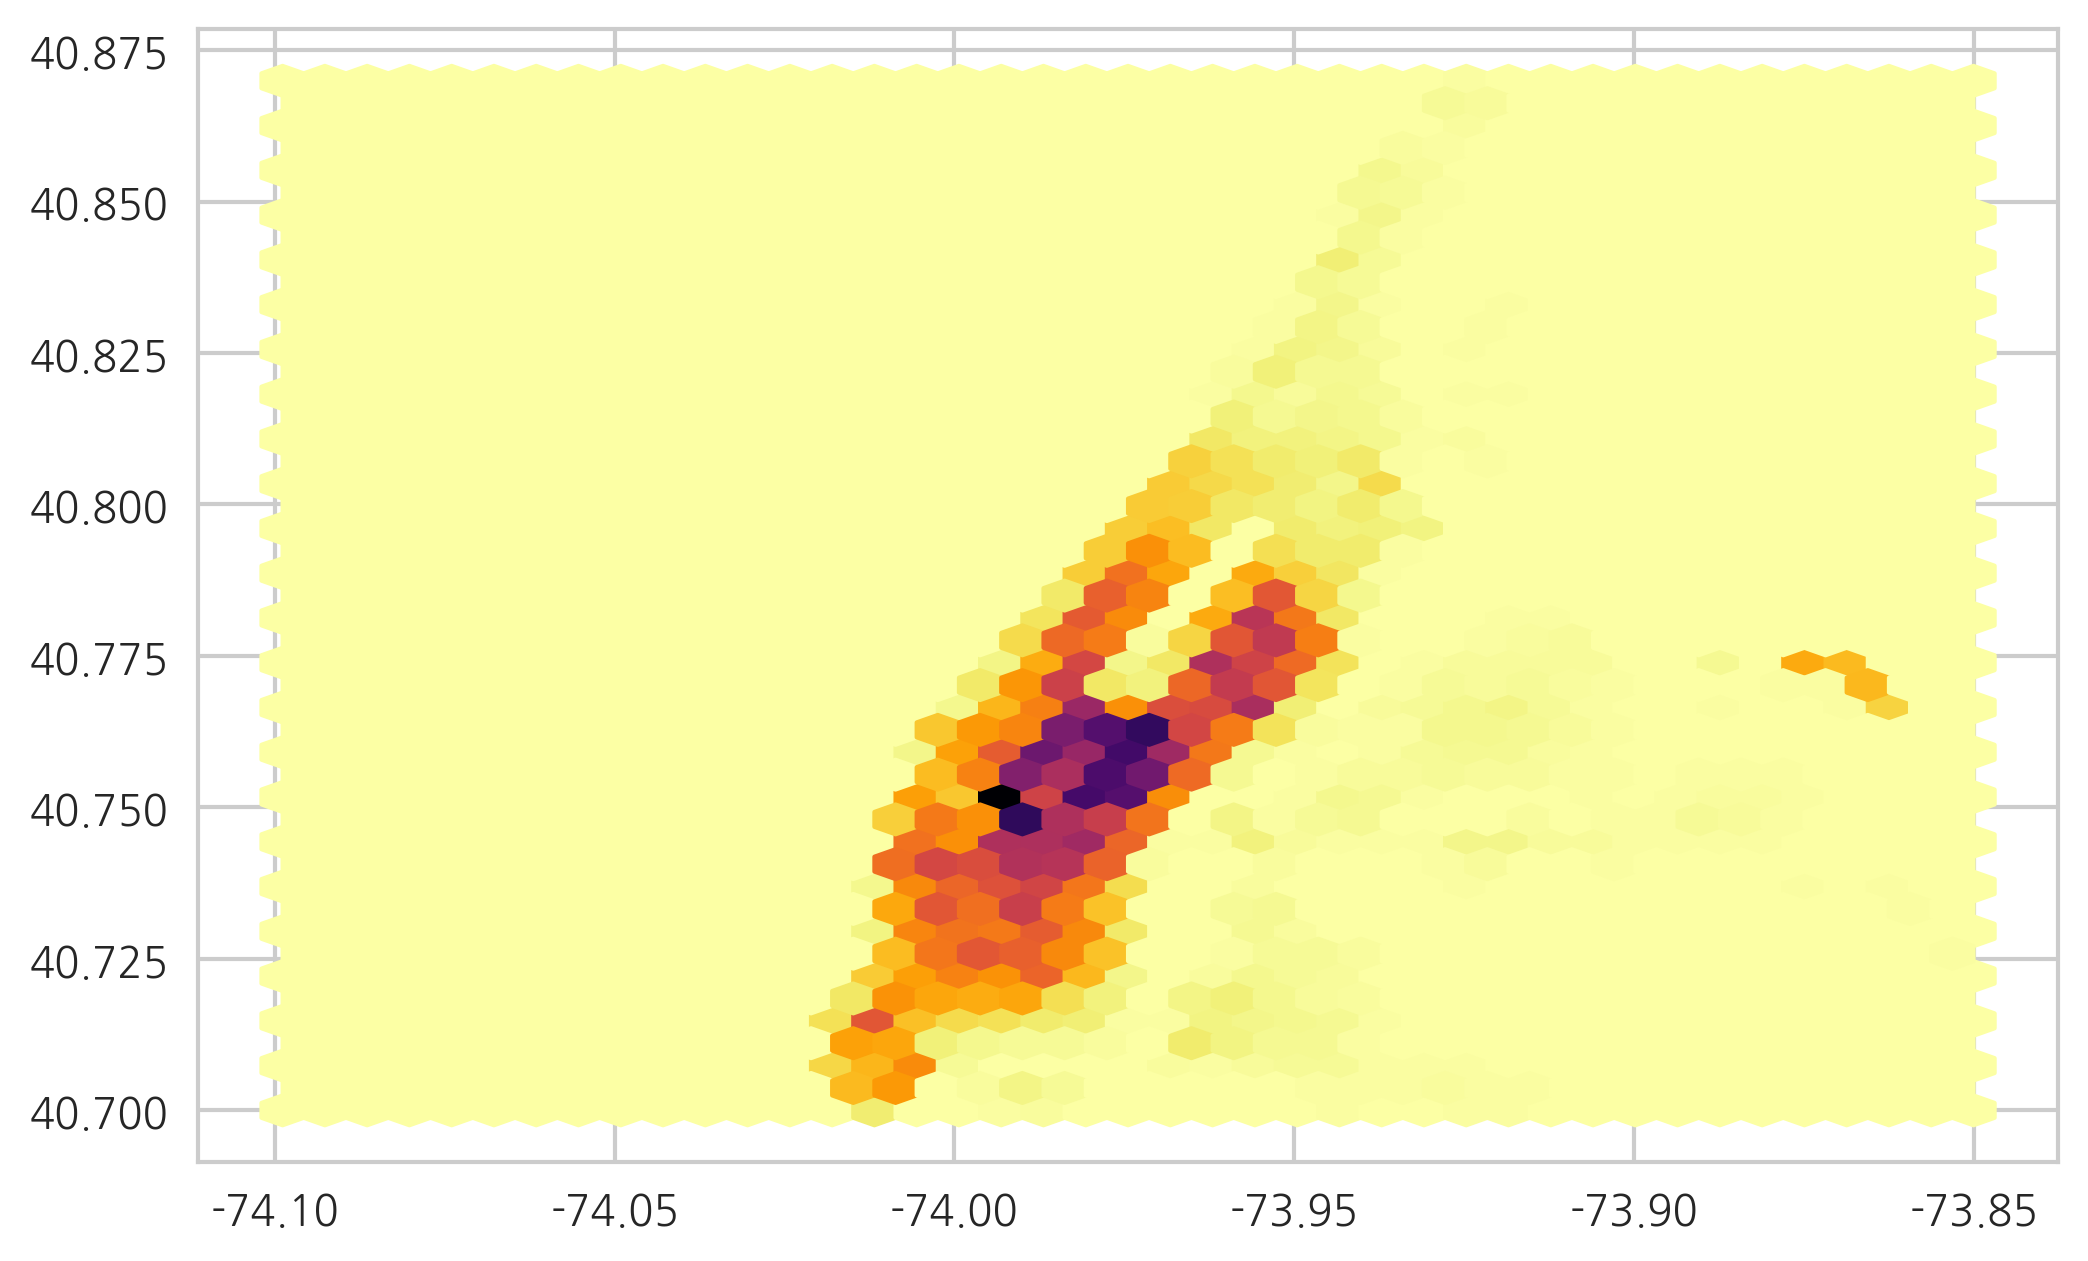

In [46]:
plt.hexbin(filtered_df['pickup_longitude'], \
           filtered_df['pickup_latitude'], \
           cmap='inferno_r', gridsize=40)

plt.show()

plt.hexbin(filtered_df['dropoff_longitude'], \
           filtered_df['dropoff_latitude'], \
           cmap='inferno_r', gridsize=40)

In [53]:
# lat [40, 41.5] long [-75, -72]
#print(taxi_df[taxi_df['pickup_longitude'] > -72])
print(taxi_df[(taxi_df['pickup_longitude'] == taxi_df['dropoff_longitude']) \
              & (taxi_df['pickup_latitude'] == taxi_df['dropoff_latitude'])].shape)
#print(test_df[test_df['pickup_longitude'] > -72])
print(test_df.shape)
print(test_df[(test_df['pickup_longitude'] == test_df['dropoff_longitude']) \
              & (test_df['pickup_latitude'] == test_df['dropoff_latitude'])].shape)

(2807, 7)
(346797, 6)
(1479, 6)


In [104]:
small_df['pickup_datetime'] = small_df['pickup_datetime'].apply(conv_time)
small_df.tail(10)

C:\Users\jchoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
490,id1056061,2,1.462024e+09,4/30/16 22:56,2,-73.974472,40.783440,-73.986488,40.766918,N,769
491,id0189801,1,1.462024e+09,4/30/16 22:59,1,-73.988785,40.760143,-73.944092,40.801037,N,988
492,id3616886,2,1.462024e+09,4/30/16 22:50,5,-73.950233,40.779888,-73.959549,40.767056,N,413
493,id2341498,2,1.462024e+09,4/30/16 22:57,1,-74.002754,40.708622,-73.981682,40.724411,N,825
494,id3202081,1,1.462024e+09,4/30/16 23:15,1,-73.983215,40.749416,-73.958427,40.721882,N,1873
495,id0323907,2,1.462024e+09,4/30/16 22:53,1,-73.962646,40.768097,-73.986633,40.766670,N,605
496,id2801006,2,1.462024e+09,4/30/16 22:52,1,-73.976486,40.751034,-73.988449,40.727509,N,604
497,id0293817,1,1.462024e+09,4/30/16 22:53,1,-74.000450,40.737656,-73.985603,40.738041,N,681
498,id3165898,2,1.462024e+09,4/30/16 22:51,1,-73.979980,40.754486,-73.985054,40.761051,N,536
499,id1930774,1,1.462024e+09,4/30/16 22:50,1,-73.992058,40.714989,-74.007812,40.705791,N,451


In [82]:
# 날짜 string을 int (Unix time)으로 바꿔주는 함수
# 'mo/dd/yy hh:mm'

def conv_time(mydate):
    vals = re.search(r'^(\d{1,2})/(\d{1,2})/(\d{1,2})\s+(\d{1,2}):(\d{1,2})', mydate)
    mo, dd, yy, hh, mm = map(int, (vals[1], vals[2], vals[3], vals[4], vals[5]))
    d1 = datetime.datetime(int(yy)+2000, mo, dd, hh, mm)
    # print(d1.timetuple())
    return time.mktime(d1.timetuple())

In [85]:
conv_time(small_df.iloc[2, 3])

1462029420.0

In [56]:
testdate = small_df.iloc[2, 2]
print(testdate)
vals = re.search(r'^(\d{1,2})/(\d{1,2})/(\d{1,2})\s+(\d{1,2}):(\d{1,2})', testdate)
mo, dd, yy, hh, mm = vals[1], vals[2], vals[3], vals[4], vals[5]
print(mo, dd, yy, hh, mm)
mo, dd, yy, hh, mm = map(int, (mo, dd, yy, hh, mm))
d1 = datetime.datetime(int(yy)+2000, mo, dd, hh, mm)
print(d1)
print(d1.timetuple())
time.mktime(d1.timetuple())

4/30/16 23:59
4 30 16 23 59
2016-04-30 23:59:00
time.struct_time(tm_year=2016, tm_mon=4, tm_mday=30, tm_hour=23, tm_min=59, tm_sec=0, tm_wday=5, tm_yday=121, tm_isdst=-1)


1462028340.0

In [105]:
small_df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
495,id0323907,2,1.462024e+09,4/30/16 22:53,1,-73.962646,40.768097,-73.986633,40.766670,N,605
496,id2801006,2,1.462024e+09,4/30/16 22:52,1,-73.976486,40.751034,-73.988449,40.727509,N,604
497,id0293817,1,1.462024e+09,4/30/16 22:53,1,-74.000450,40.737656,-73.985603,40.738041,N,681
498,id3165898,2,1.462024e+09,4/30/16 22:51,1,-73.979980,40.754486,-73.985054,40.761051,N,536
499,id1930774,1,1.462024e+09,4/30/16 22:50,1,-73.992058,40.714989,-74.007812,40.705791,N,451


In [94]:
small_df['pickup_datetime'] = small_df['pickup_datetime'].apply(conv_time)
small_df['pickup_datetime'].tail()

C:\Users\jchoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


495    1.462024e+09
496    1.462024e+09
497    1.462024e+09
498    1.462024e+09
499    1.462024e+09
Name: pickup_datetime, dtype: float64

In [100]:
small_df['longitude_diff'] = small_df['dropoff_longitude'] - small_df['pickup_longitude']
small_df.loc[:, 'latitude_diff'] = small_df['dropoff_latitude'] - small_df['pickup_latitude']

C:\Users\jchoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jchoi\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jchoi\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [106]:
# reference: https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

mod = smf.ols(formula = 'trip_duration ~ pickup_datetime\
            + passenger_count + pickup_longitude + pickup_latitude \
            + dropoff_longitude + dropoff_latitude', data=small_df)

res = mod.fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                   0.09086
Date:                Mon, 02 Oct 2017   Prob (F-statistic):              0.994
Time:                        12:52:12   Log-Likelihood:                -5007.6
No. Observations:                 500   AIC:                         1.003e+04
Df Residuals:                     494   BIC:                         1.005e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0096      0.02

In [101]:
# reference: https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

mod = smf.ols(formula = 'trip_duration ~ passenger_count\
            + longitude_diff \
            + latitude_diff', data=small_df)

res = mod.fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1024
Date:                Mon, 02 Oct 2017   Prob (F-statistic):              0.959
Time:                        12:49:31   Log-Likelihood:                -5007.7
No. Observations:                 500   AIC:                         1.002e+04
Df Residuals:                     496   BIC:                         1.004e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1214.0168    409.218     